# Learning Objectives

- Determine if stratefiedshuffle split is the best approach
- Recognize how to identify the optimal number of trees
- Understand the resulting plot of out-of-band errors
- Explore Random Forest vs Extra Random Trees and determine which one worked better
- Apply Intel® Extension for Scikit-learn* to leverage underlying compute capabilities of hardware


## Introduction

We will use the wine quality data set again and compare our results to the decion tree results. This data set contains various chemical properties of wine, such as acidity, sugar, pH, and alcohol. It also contains a quality metric (3-9, with highest being better) and a color (red or white). The name of the file is `Wine_Quality_Data.csv`.

In [1]:
from __future__ import print_function
import os
data_path = ['data']

#from sklearnex import patch_sklearn
#patch_sklearn()
#unpatch_sklearn()

from io import StringIO
from IPython.display import Image, display
import time

from sklearn.tree import export_graphviz
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier

## Exercise 1

* Import the data and examine the features.
* We will be using all of them to predict `color` (white or red), but the colors feature will need to be integer encoded.

In [2]:
import pandas as pd
import numpy as np

filepath = os.sep.join(data_path + ['Wine_Quality_Data.csv'])
data = pd.read_csv(filepath, sep=',')

In [ ]:
# Examine the top 5 rows of the data
data.head()

In [ ]:
# What types of data do we have?
data.dtypes

In [ ]:
# How many rows of data are there?
data.shape[0]

Convert the color feature to an integer. This is a quick way to do it using Pandas.

In [3]:
data['color'] = data.color.replace('white',0).replace('red',1).astype(int)

## Exercise 2

* Examine distribution of the predicted variable `color`.
* Split the data into train and test sets. Again use `StratifiedShuffleSplit`.

In [4]:
# All data columns except for color
feature_cols = [x for x in data.columns if x not in 'color']

In [5]:
# Split the data into two parts with 1000 points in the test data
# This creates a generator
strat_shuff_split = StratifiedShuffleSplit(n_splits=1, test_size=1000, random_state=42)

# Get the index values from the generator
train_idx, test_idx = next(strat_shuff_split.split(data[feature_cols], data['color']))

# Create the data sets
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'color']

X_test = data.loc[test_idx, feature_cols]
y_test = data.loc[test_idx, 'color']

strat_shuff_split.get_n_splits(X_train,y_test)

1

Now check the percent composition of each quality level in the train and test data sets. The data set is mostly white wine, as can be seen below. 0 for white 1 for red.

In [6]:
y_train.value_counts(normalize=True).sort_index()

0    0.753866
1    0.246134
Name: color, dtype: float64

In [7]:
y_test.value_counts(normalize=True).sort_index()

0    0.754
1    0.246
Name: color, dtype: float64

## Exercise 3

* Fit random forest models with a range of tree numbers and evaluate the out-of-bag error for each of these models.
* Plot the resulting oob errors as a function of the number of trees.

*Hint:* since the only thing changing is the number of trees, the `warm_start` flag can be used so that the model just adds more trees to the existing model each time. Use the `set_params` method to update the number of trees.

In [8]:
# Suppress warnings about too few trees from the early models

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [9]:
#from sklearnex import patch_sklearn, unpatch_sklearn
#unpatch_sklearn
#patch_sklearn()
from sklearn.ensemble import RandomForestClassifier

# Initialize the random forest estimator
# Note that the number of trees is not setup here
RF = RandomForestClassifier(oob_score=True, 
                            random_state=42, 
                            warm_start=True,
                            n_jobs=-1)

oob_list = list()

# Iterate through all of the possibilities for 
# number of trees

for n_trees in [25, 50, 100, 150, 200, 300, 400]:
    
    # Use this to set the number of trees
    RF.set_params(n_estimators=n_trees)
    
    # Time fit function
    t = time.process_time()

    # Fit the model
    RF.fit(X_train, y_train)
    elapsed_time = time.process_time() - t
    
    # Get the oob error
    oob_error = 1 - RF.oob_score_
    
    # Store it
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

rf_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

print ("It took",elapsed_time," to fit.")

rf_oob_df

It took 1.8842621510000006  to fit.


,oob
n_trees,
25.0,0.008004
50.0,0.005821
100.0,0.005094
150.0,0.004730
200.0,0.005094
300.0,0.004912
400.0,0.005094


Where has the error stabilized?  Plot the out of bag error to see the result.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

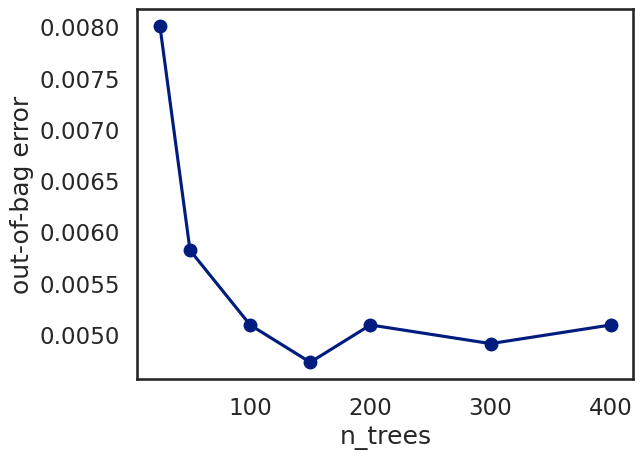

In [11]:
sns.set_context('talk')
sns.set_palette('dark')
sns.set_style('white')

ax = rf_oob_df.plot(legend=False, marker='o')
ax.set(ylabel='out-of-bag error');

## Exercise 4

* Repeat question 3 using extra randomized trees `ExtraTreesClassifier`. Note that the `bootstrap` parameter will have to be set to `True` for this model.
* Compare the out-of-bag errors for the two different types of models.

In [12]:
from sklearn.ensemble import ExtraTreesClassifier

# Initialize the random forest estimator
# Note that the number of trees is not setup here
EF = ExtraTreesClassifier(oob_score=True, 
                          random_state=42, 
                          warm_start=True,
                          bootstrap=True,
                          n_jobs=-1)

oob_list = list()

# Iterate through all of the possibilities for 
# number of trees
for n_trees in [25, 50, 100, 150, 200, 300, 400]:
    
    # Use this to set the number of trees
    EF.set_params(n_estimators=n_trees)
    
    # Time fit function
    t = time.process_time()
    EF.fit(X_train, y_train)
    elapsed_time = time.process_time() - t
    
    # oob error
    oob_error = 1 - EF.oob_score_
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

et_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

et_oob_df

,oob
n_trees,
25.0,0.005276
50.0,0.004002
100.0,0.004912
150.0,0.004184
200.0,0.004184
300.0,0.004366
400.0,0.004366


In [13]:
oob_df = pd.concat([rf_oob_df.rename(columns={'oob':'RandomForest'}),
                    et_oob_df.rename(columns={'oob':'ExtraTrees'})], axis=1)

oob_df

,RandomForest,ExtraTrees
n_trees,,
25.0,0.008004,0.005276
50.0,0.005821,0.004002
100.0,0.005094,0.004912
150.0,0.004730,0.004184
200.0,0.005094,0.004184
300.0,0.004912,0.004366
400.0,0.005094,0.004366


In [14]:
print ("It took",elapsed_time,"to fit.")

It took 1.4816705860000017 to fit.


Why do you think the extra trees out performed the RandomForest?

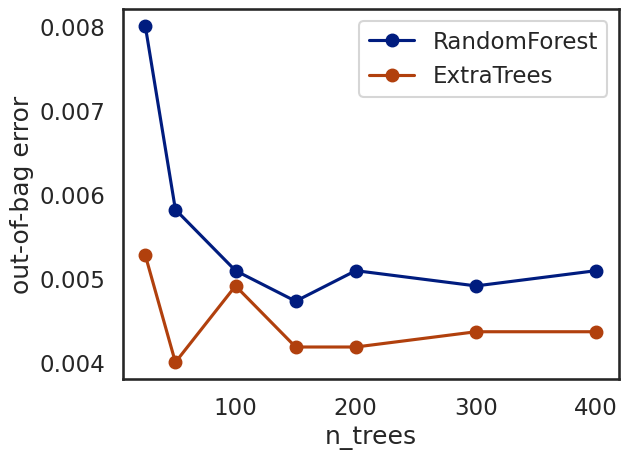

In [15]:
sns.set_context('talk')
sns.set_palette('dark')
sns.set_style('white')

ax = oob_df.plot(marker='o')
ax.set(ylabel='out-of-bag error');

## Exercise 5

* Select one of the models that performs well and calculate error metrics and a confusion matrix on the test data set. 
* Given the distribution of the predicted class, which metric is most important? Which could be deceiving?

In [16]:
# Random forest with extra trees 50 estimators
model = RF.set_params(n_estimators=50)
t = time.process_time()
y_pred = model.predict(X_test)
elapsed_time = time.process_time() - t

In [17]:
print ("It took",elapsed_time,"seconds to predict.")

It took 0.4701258209999999 seconds to predict.


In [18]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

cr = classification_report(y_test, y_pred)
print(cr)

score_df = pd.DataFrame({'accuracy': accuracy_score(y_test, y_pred),
                         'precision': precision_score(y_test, y_pred),
                         'recall': recall_score(y_test, y_pred),
                         'f1': f1_score(y_test, y_pred),
                         'auc': roc_auc_score(y_test, y_pred)},
                         index=pd.Index([0]))

print(score_df)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       754
           1       1.00      0.99      0.99       246

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000

   accuracy  precision   recall       f1       auc
0     0.997   0.995918  0.99187  0.99389  0.995272


Text(0.5, 6.8833333333333275, 'Ground Truth')

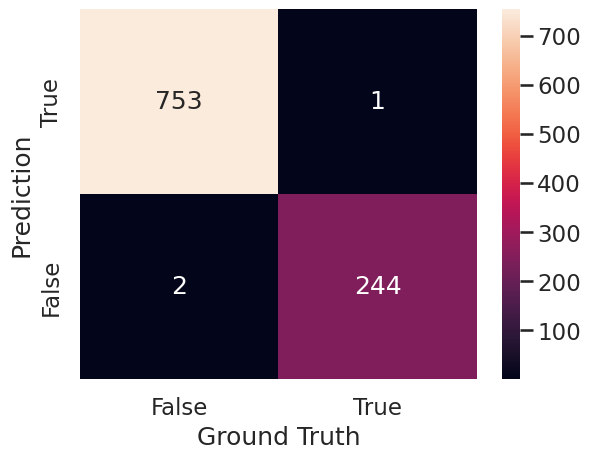

In [19]:
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix

sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

labels = ['False', 'True']
ax.set_xticklabels(labels);
ax.set_yticklabels(labels[::-1]);
ax.set_ylabel('Prediction');
ax.set_xlabel('Ground Truth')

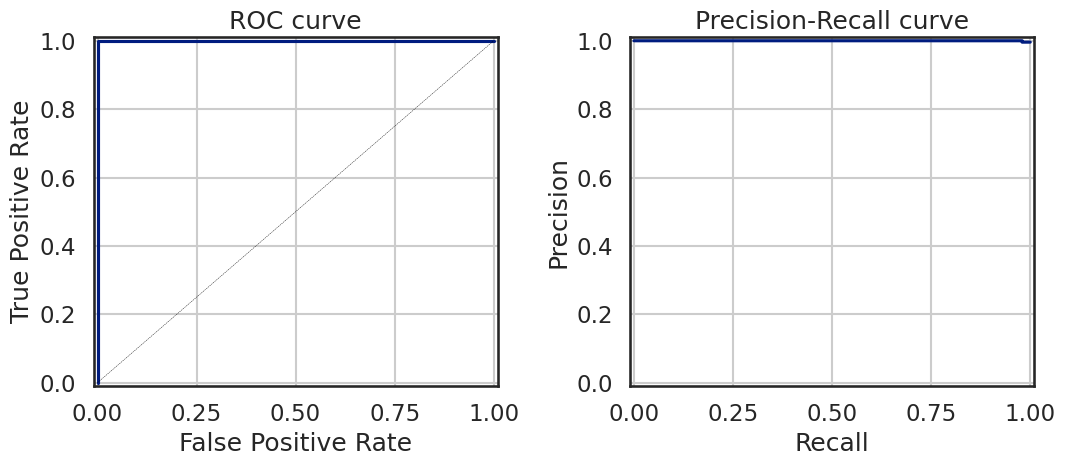

In [20]:
sns.set_context('talk')

fig, axList = plt.subplots(ncols=2)
fig.set_size_inches(11, 5)

# Get the probabilities for each of the two categories
y_prob = model.predict_proba(X_test)

# Plot the ROC-AUC curve
ax = axList[0]

fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
ax.plot(fpr, tpr)
# It is customary to draw a diagonal dotted line in ROC plots.
# This is to indicate completely random prediction. Deviation from this
# dotted line towards the upper left corner signifies the power of the model.
ax.plot([0, 1], [0, 1], ls='--', color='black', lw=.3)
ax.set(xlabel='False Positive Rate',
       ylabel='True Positive Rate',
       xlim=[-.01, 1.01], ylim=[-.01, 1.01],
       title='ROC curve')
ax.grid(True)

# Plot the precision-recall curve
ax = axList[1]

precision, recall, _ = precision_recall_curve(y_test, y_prob[:,1])
ax.plot(recall, precision)
ax.set(xlabel='Recall', ylabel='Precision',
       xlim=[-.01, 1.01], ylim=[-.01, 1.01],
       title='Precision-Recall curve')
ax.grid(True)

plt.tight_layout()

### Which feature was most important, plot the biggest predictor. Use `feature_importances_` 

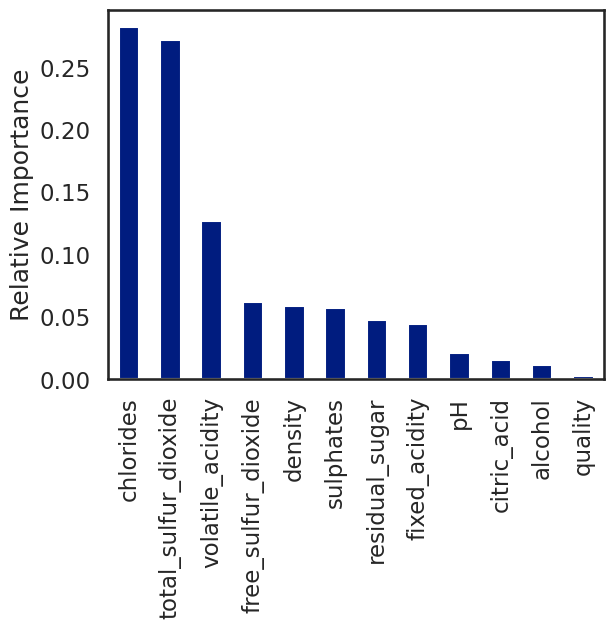

In [21]:
feature_imp = pd.Series(model.feature_importances_, index=feature_cols).sort_values(ascending=False)

ax = feature_imp.plot(kind='bar')
ax.set(ylabel='Relative Importance');